In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Plots import lens_plot
import lenstronomy.Util.param_util as param_util
from lenstronomy.Data.pixel_grid import PixelGrid
import lenstronomy.Util.image_util as image_util
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from astropy.cosmology import Planck13
from lenstronomy.Util import data_util
import h5py
from lenstronomy.LensModel.LightConeSim.light_cone import LightCone
import astropy.units as u
from lenstronomy.SimulationAPI.sim_api import SimAPI

%matplotlib inline

/fred/oz149/Tyler/pyenv/pytorch/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


## Light Model

In [2]:
# SOURCE
source_light_model_list = ['SERSIC_ELLIPSE']
source_centre_x = 0
source_centre_y = 0
e1_source, e2_source = param_util.phi_q2_ellipticity(phi=0, q=0.9)
kwargs_source_light = [{'amp': 500, 'R_sersic': 0.5, 'n_sersic': 4, 'e1': e1_source, 'e2': e2_source, 'center_x': source_centre_x, 'center_y': source_centre_y}]

lightModel_source = LightModel(light_model_list=source_light_model_list)

# LENS
lens_light_model_list = ['SERSIC_ELLIPSE']
e1_lens, e2_lens = param_util.phi_q2_ellipticity(phi=0, q=1)
kwargs_lens_light = [{'amp': 1000, 'R_sersic': 0.1, 'n_sersic': 4, 'e1': 0.1, 'e2': 0.1, 'center_x': 0, 'center_y': 0}]

lightModel_lens = LightModel(light_model_list=lens_light_model_list)

# Lens Model

/tmp/ipykernel_1735471/413568973.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


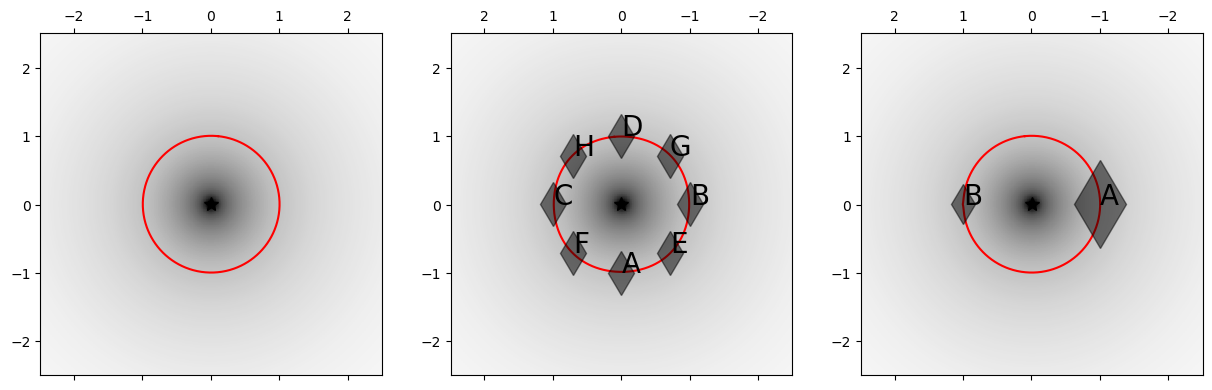

In [3]:
# SIE
sie_lens_model_list = ['SIE']
kwargs_sie = [{'theta_E': 1, 'e1': e1_lens, 'e2': e2_lens, 'center_x': 0, 'center_y': 0}]
lensModel_sie = LensModel(lens_model_list=sie_lens_model_list)

# EPL+OCTOPOLE
boxydisky_lens_model_list = ['EPL_BOXYDISKY']
kwargs_boxydisky = [{'theta_E': 1, 'gamma': 2, 'e1': e1_lens, 'e2': e2_lens, 'center_x': 0, 'center_y': 0, 'a_m': -0.01}]
lensModel_boxydisky = LensModel(lens_model_list=boxydisky_lens_model_list)

# SIE+TNFW
lensCosmo = LensCosmo(z_lens=0.5, z_source=1, cosmo=Planck13)
Rs_angle, alpha_Rs = lensCosmo.nfw_physical2angle(10**8, 6)

sie_tnfw_lens_model_list = ['SIE', 'TNFW']
kwargs_sie_tnfw = [{'theta_E': 1, 'e1': e1_lens, 'e2': e2_lens, 'center_x': 0, 'center_y': 0}, 
                   {'Rs': Rs_angle, 'alpha_Rs': alpha_Rs, 'r_trunc': 5*0.1, 'center_x': 1, 'center_y': 0}]
lensModel_sie_tnfw = LensModel(lens_model_list=sie_tnfw_lens_model_list)


# VISUALIZATION
f, axex = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(axex[0], lensModel=lensModel_sie, kwargs_lens=kwargs_sie, sourcePos_x=source_centre_x, sourcePos_y=source_centre_y, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)
lens_plot.lens_model_plot(axex[1], lensModel=lensModel_boxydisky, kwargs_lens=kwargs_boxydisky, sourcePos_x=source_centre_x, sourcePos_y=source_centre_y, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=True)
lens_plot.lens_model_plot(axex[2], lensModel=lensModel_sie_tnfw, kwargs_lens=kwargs_sie_tnfw, sourcePos_x=source_centre_x, sourcePos_y=source_centre_y, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=True)
f.show()

# Data Model

In [205]:
# import the PixelGrid() class #
deltaPix = 0.03  # size of pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
ra_at_xy_0, dec_at_xy_0 = -3, -3 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': 200, 'ny': 200,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates
# compute pixel value of a coordinate position #
x_pos, y_pos = pixel_grid.map_coord2pix(ra=0, dec=0)
# compute the coordinate value of a pixel position #
ra_pos, dec_pos = pixel_grid.map_pix2coord(x=20, y=10)

# import the PSF() class #
from lenstronomy.Data.psf import PSF
kwargs_psf = {'psf_type': 'GAUSSIAN',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
              'fwhm': 0.08,  # full width at half maximum of the Gaussian PSF (in angular units)
              'pixel_size': deltaPix  # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
             }
psf = PSF(**kwargs_psf)
# return the pixel kernel corresponding to a point source # 
kernel = psf.kernel_point_source

# Image Model

/tmp/ipykernel_1735471/2892306050.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


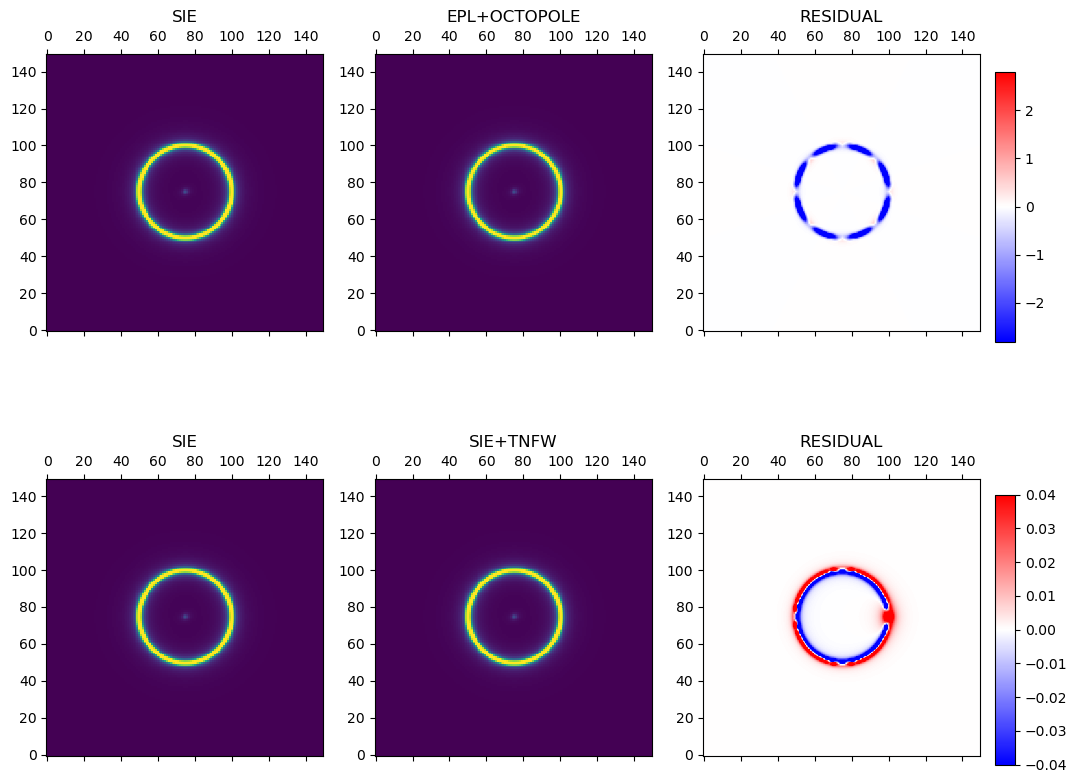

In [5]:
# define the numerics #
kwargs_numerics = {'supersampling_factor': 10, # each pixel gets super-sampled (in each axis direction) 
                  'supersampling_convolution': False}

# SIE
# initialize the Image model class by combining the modules we created above #
imageModel_sie = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel_sie,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        point_source_class=None, # in this example, we do not simulate point source.
                        kwargs_numerics=kwargs_numerics)
# simulate image with the parameters we have defined above #
image_sie = imageModel_sie.image(kwargs_lens=kwargs_sie, kwargs_source=kwargs_source_light,
                         kwargs_lens_light=kwargs_lens_light, kwargs_ps=kwargs_psf)

# EPL_OCTOPOLE
# initialize the Image model class by combining the modules we created above #
imageModel_boxydisky = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel_boxydisky,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        point_source_class=None, # in this example, we do not simulate point source.
                        kwargs_numerics=kwargs_numerics)
# simulate image with the parameters we have defined above #
image_boxydisky = imageModel_boxydisky.image(kwargs_lens=kwargs_boxydisky, kwargs_source=kwargs_source_light,
                         kwargs_lens_light=kwargs_lens_light, kwargs_ps=kwargs_psf)

# SIE+TNFW
# initialize the Image model class by combining the modules we created above #
imageModel_sie_tnfw = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel_sie_tnfw,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        point_source_class=None, # in this example, we do not simulate point source.
                        kwargs_numerics=kwargs_numerics)
# simulate image with the parameters we have defined above #
image_sie_tnfw = imageModel_sie_tnfw.image(kwargs_lens=kwargs_sie_tnfw, kwargs_source=kwargs_source_light,
                         kwargs_lens_light=kwargs_lens_light, kwargs_ps=kwargs_psf)


# exp_time = 100  # exposure time to quantify the Poisson noise level
# background_rms = 0.1  # background rms value
# poisson = image_util.add_poisson(image, exp_time=exp_time)
# bkg = image_util.add_background(image, sigma_bkd=background_rms)

vmax = np.percentile(image_sie, 99)

# take the largest of the absolute values of the max and min values
vmax_residual = np.max([np.abs(np.percentile(image_boxydisky-image_sie, 99)), np.abs(np.percentile(image_boxydisky-image_sie, 1))])


f, axes = plt.subplots(2, 3, figsize=(10, 9))
axes[0,0].matshow(image_sie, origin='lower', vmax=vmax)
axes[0,1].matshow(image_boxydisky, origin='lower', vmax=vmax)
axes[0,2].matshow(image_boxydisky-image_sie, origin='lower', cmap='bwr',vmax=vmax_residual, vmin=-vmax_residual )

axes[0,0].set_title("SIE")
axes[0,1].set_title("EPL+OCTOPOLE")
axes[0,2].set_title("RESIDUAL")

# add colourbar to the third plot
cax = f.add_axes([1, 0.57, 0.02, 0.3])
f.colorbar(axes[0,2].imshow(image_boxydisky-image_sie, origin='lower', cmap='bwr', vmax=vmax_residual, vmin=-vmax_residual), cax=cax)

vmax_residual = np.max([np.abs(np.percentile(image_sie_tnfw-image_sie, 99)), np.abs(np.percentile(image_sie_tnfw-image_sie, 1))])

axes[1,0].matshow(image_sie, origin='lower', vmax=vmax)
axes[1,1].matshow(image_sie_tnfw, origin='lower', vmax=vmax)
axes[1,2].matshow(image_sie_tnfw-image_sie, origin='lower', cmap='bwr', vmax=vmax_residual, vmin=-vmax_residual)

axes[1,0].set_title("SIE")
axes[1,1].set_title("SIE+TNFW")
axes[1,2].set_title("RESIDUAL")

# add colourbar to the third plot
cax = f.add_axes([1, 0.1, 0.02, 0.3])
f.colorbar(axes[1,2].imshow(image_sie_tnfw-image_sie, origin='lower', cmap='bwr', vmax=vmax_residual, vmin=-vmax_residual), cax=cax)

f.tight_layout()
plt.show()

# TNG ETG Mass Profile
---
The point was raised that if an ML model can overfit to a single simulation and then recover it's subhalo mass function, then it serves as a good indication that the CNN will generalise well to 

## Light Profile

### Lens

15.091161


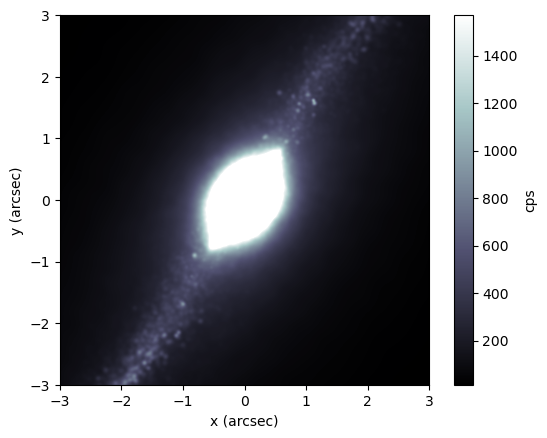

In [109]:
with h5py.File('../data/test_images/grid_halo_TNG50-1_91_18_LensLight_jwstf070w.hdf5', 'r') as f:
    galaxy_image = f['grid'][:]

# Convert mag to flux
mag_zero_point = 26

mag_lens = np.min(galaxy_image)
print(mag_lens)

galaxy_image = data_util.magnitude2cps(galaxy_image, mag_zero_point)

vmax = np.percentile(galaxy_image, 96)

plt.imshow(galaxy_image, origin='lower', cmap='bone', vmax=vmax, extent=[-3, 3, -3, 3])
plt.xlabel('x (arcsec)')
plt.ylabel('y (arcsec)')
plt.colorbar(label='cps')


#kwargs
kwargs_lens_light_custom = [{'image': galaxy_image, 'magnitude': 18, 'center_x': 0, 'center_y': 0, 'phi_G': 0, 'scale': 0.0075}
                    ]

In [10]:
major_axis_slice = galaxy_image[400,:]
minor_axis_slice = galaxy_image[:,400]

FWHM_major = np.sum(major_axis_slice > 0.5*np.max(major_axis_slice))
FWHM_minor = np.sum(minor_axis_slice > 0.5*np.max(minor_axis_slice))

print(FWHM_major, FWHM_minor)

axis_ratio = FWHM_minor/FWHM_major

print(axis_ratio)

252 86
0.3412698412698413


### Source

19.158894


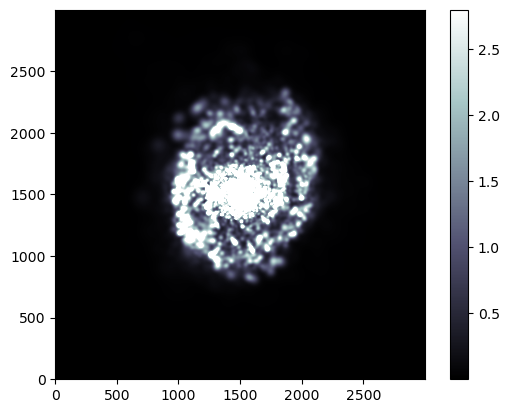

In [201]:
with h5py.File('../data/test_images/grid_halo_TNG50-1_50_658_SourceLight_jwstf070w.hdf5', 'r') as f:
    source_image = f['grid'][:]

mag_source = np.min(source_image)
print(mag_source)

source_image = data_util.magnitude2cps(source_image, mag_zero_point)

vmax = np.percentile(source_image, 96.5)

plt.imshow(source_image, origin='lower', cmap='bone', vmax=vmax)
plt.colorbar()

source_centre_x = np.random.uniform(-0.5, 0.5)
source_centre_y = np.random.uniform(-0.5, 0.5)

#kwargs
kwargs_source_light_custom = [{'image': source_image, 'magnitude': 22, 'center_x': source_centre_x, 'center_y': source_centre_y, 'phi_G': 0, 'scale': 0.002}
                    ]

## Mass Profile

Total mass: 11.517741203308105 [log10(Msun)]
---------------------------------------------
Dark Matter mass fraction: 0.34
Gas mass fraction: 0.00438
Stellar mass fraction: 0.65


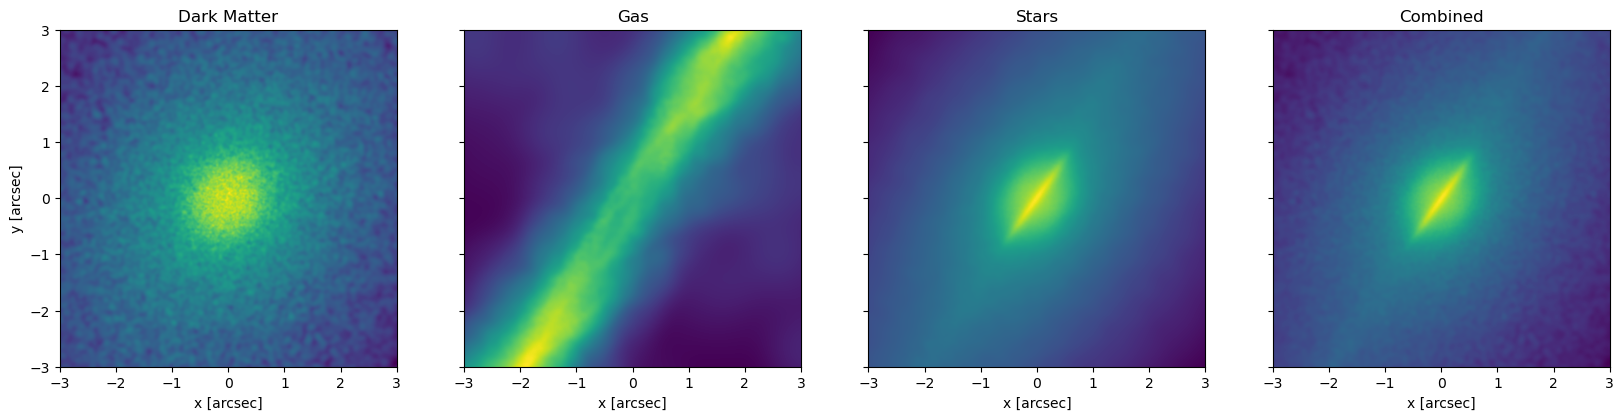

In [163]:
fig, ax = plt.subplots(1, 4, figsize=(20, 10), sharex=True, sharey=True)

## Dark Matter
with h5py.File('../data/test_images/grid_halo_TNG50-1_91_18_LensMass_dm.hdf5', 'r') as f:
    dm_surface_mass_density = f['grid'][:]

ax[0].imshow(dm_surface_mass_density, origin='lower', extent=[-3, 3, -3, 3])
ax[0].set_title('Dark Matter')
ax[0].set_xlabel('x [arcsec]')
ax[0].set_ylabel('y [arcsec]')

## Gas
with h5py.File('../data/test_images/grid_halo_TNG50-1_91_18_LensMass_gas.hdf5', 'r') as f:
    gas_surface_mass_density = f['grid'][:]

ax[1].imshow(gas_surface_mass_density, origin='lower', extent=[-3, 3, -3, 3])
ax[1].set_title('Gas')
ax[1].set_xlabel('x [arcsec]')

## Stars
with h5py.File('../data/test_images/grid_halo_TNG50-1_91_18_LensMass_stellar.hdf5', 'r') as f:
    stellar_surface_mass_density = f['grid'][:]

ax[2].imshow(stellar_surface_mass_density, origin='lower', extent=[-3, 3, -3, 3])
ax[2].set_title('Stars')
ax[2].set_xlabel('x [arcsec]')

## Combine all components

combined_surface_mass_density = np.log10(10**dm_surface_mass_density + 10**gas_surface_mass_density + 10**stellar_surface_mass_density)

ax[3].imshow(combined_surface_mass_density, origin='lower', extent=[-3, 3, -3, 3])
ax[3].set_title('Combined')
ax[3].set_xlabel('x [arcsec]')

## Total Masses
total_mass = np.log10(np.sum(10**combined_surface_mass_density))
dm_mass = np.log10(np.sum(10**dm_surface_mass_density))
gas_mass = np.log10(np.sum(10**gas_surface_mass_density))
stellar_mass = np.log10(np.sum(10**stellar_surface_mass_density))


dm_mass_frac = dm_mass - total_mass
gas_mass_frac = gas_mass - total_mass
stellar_mass_frac = stellar_mass - total_mass

print(f"Total mass: {total_mass} [log10(Msun)]")
print("-"*45)
print(f"Dark Matter mass fraction: {np.round(10**dm_mass_frac,2)}")
print(f"Gas mass fraction: {np.round(10**gas_mass_frac,5)}")
print(f"Stellar mass fraction: {np.round(10**stellar_mass_frac,2)}")

In [164]:
cosmo = Planck13
z_lens = 0.1
z_source = 1

# Example angular size in arcseconds
angular_size_arcsec = 0.0075

# Convert arcseconds to arcminutes
angular_size_arcmin = angular_size_arcsec / 60.0

# Calculate kpc per arcminute at z_lens
kpc_per_arcmin = cosmo.kpc_proper_per_arcmin(z_lens)

print(kpc_per_arcmin)

# Calculate the physical size in kpc
size_kpc = angular_size_arcmin * kpc_per_arcmin

# Convert the physical size to Mpc
size_Mpc = (size_kpc/1000).value

print(size_Mpc)

lightcone = LightCone([10**combined_surface_mass_density], [size_Mpc], [z_lens])
lens_model_custom, kwargs_lens_custom = lightcone.cone_instance(z_source, cosmo, multi_plane=True)

114.22531344200326 kpc / arcmin
1.4278164180250408e-05


<AxesSubplot:>

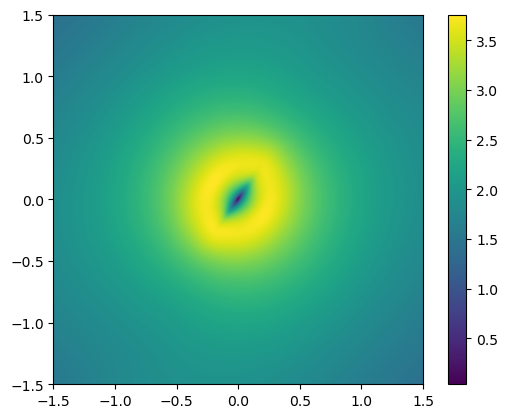

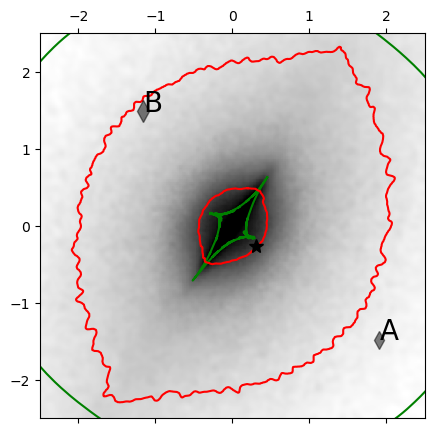

In [202]:
ra_at_xy_0, dec_at_xy_0 = -3, -3 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle_temp = np.array([[1, 0], [0, 1]]) * 0.0075  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel_temp = {'nx': 800, 'ny': 800,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle_temp} 
pixel_grid_temp = PixelGrid(**kwargs_pixel_temp)
# return the list of pixel coordinates #
x_coords_temp, y_coords_temp = pixel_grid_temp.pixel_coordinates

alpha = lens_model_custom.alpha(x_coords_temp, y_coords_temp, kwargs_lens_custom)

plt.imshow(np.sqrt(alpha[0]**2+alpha[1]**2), origin='lower', extent=[-1.5, 1.5, -1.5, 1.5])
plt.colorbar()

f, axex = plt.subplots(1, 1, figsize=(15, 5), sharex=False, sharey=False)
lens_plot.lens_model_plot(axex, lensModel=lens_model_custom, kwargs_lens=kwargs_lens_custom, sourcePos_x=source_centre_x, sourcePos_y=source_centre_y, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)

In [206]:
exp_time=1000

kwargs_single_band = {'read_noise': 0, 'pixel_scale': 0.03, 'ccd_gain': 0, 'exposure_time': exp_time, 'sky_brightness': 0, 'seeing': 0.08, 'magnitude_zero_point': mag_zero_point, 'num_exposures': 1, 'background_noise': 0, 'psf_type': 'GAUSSIAN'}
kwargs_model = {'lens_model_list': ['INTERPOL'], 'lens_redshift_list': [z_lens], 'lens_light_model_list': ['INTERPOL'], 'source_light_model_list': ['INTERPOL'], 'source_redshift_list': [z_source], 'point_source_model_list': [], 'cosmo': cosmo, 'z_source': z_source}


sim = SimAPI(numpix=150,
            kwargs_model=kwargs_model,
            kwargs_single_band=kwargs_single_band)

kwargs_lens_light_custom_amp, kwargs_source_light_custom_amp, _ = sim.magnitude2amplitude(kwargs_lens_light_mag=kwargs_lens_light_custom, kwargs_source_mag=kwargs_source_light_custom)

lens_light_custom_list = ['INTERPOL']
source_light_custom_list = ['INTERPOL']
lightModel_lens_custom = LightModel(light_model_list=lens_light_custom_list)
lightModel_source_custom = LightModel(light_model_list=source_light_custom_list)

imageModel_custom = ImageModel(data_class=pixel_grid, 
                        psf_class=psf, 
                        lens_model_class=lens_model_custom,
                        source_model_class=lightModel_source_custom,
                        lens_light_model_class=lightModel_lens_custom,
                        point_source_class=None, # in this example, we do not simulate point source.
                        kwargs_numerics=kwargs_numerics)
# simulate image with the parameters we have defined above #
image_custom = imageModel_custom.image(kwargs_lens=kwargs_lens_custom, 
                                        kwargs_source=kwargs_source_light_custom_amp,
                                        kwargs_lens_light=kwargs_lens_light_custom_amp,
                                        kwargs_ps=kwargs_psf)
                         

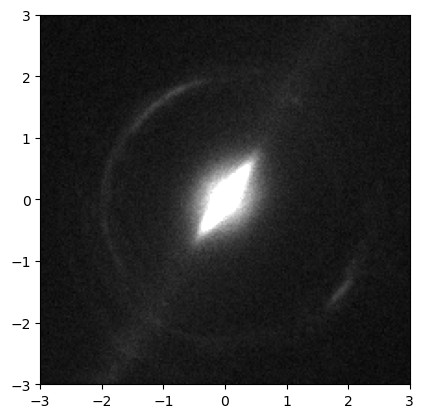

In [208]:
poisson = image_util.add_poisson(image_custom, exp_time=exp_time)
sigma_bkg = data_util.bkg_noise(10,
                                exp_time,
                                0,
                                0.02,
                                num_exposures=1)
bkg = image_util.add_background(image_custom, sigma_bkd=sigma_bkg)

vmax = np.percentile(image_custom, 99)

plt.imshow(image_custom+bkg+poisson, origin='lower', vmax=vmax, cmap='gray', extent=[-3, 3, -3, 3])